# Exercise 3:

In [1]:
#First we import the usual libraries: 
import pyvista as pv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
from IPython import display

### Part A

In [2]:
def read_units(units_path,file_path):
    '''
    This functions reads units.out file
    -------------------------------------------------------------------------
    PARAMETERS: 
    -units_path,file_path : the paths were the units and vtk files are
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns three arrays with the rho,vel,l normalisation data respectively
    -------------------------------------------------------------------------
    '''
    #Reading the units file
    units = pd.read_csv(units_path)
    
    #With .loc() we select the normalisation values for velocity.
    vel_0 = np.array(units.loc[units["variable"] == "v_0"]["normalisation"])
    
    #Reading velocity components of the vtk file:
    data = pv.read(file_path)
    
    vx1 = pv.get_array(data, "vx1", preference = 'cell') 
    vx2 = pv.get_array(data, "vx2", preference = 'cell')
    
    #Normalizing:
    vx1_norm = vx1*vel_0
    vx2_norm = vx2*vel_0
    
    return vx1_norm,vx2_norm

### Part B

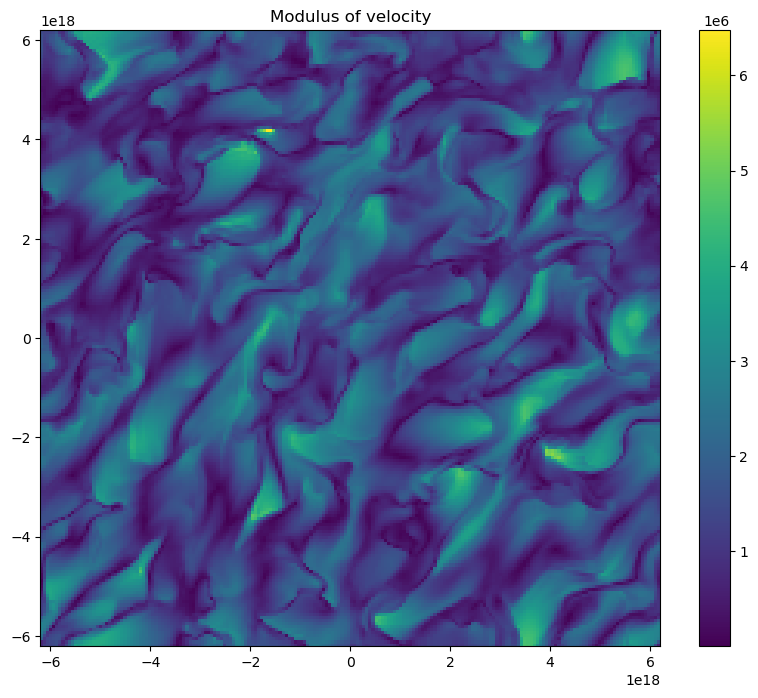

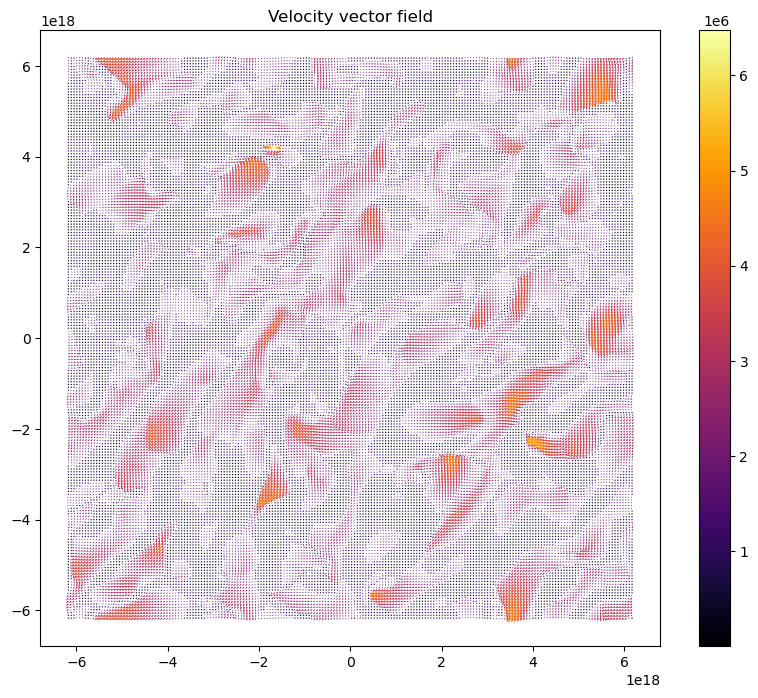

In [3]:
#Defining the paths for the files: 
units_path = "/home/jdiego/Downloads/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/units.out"
file_path = "/home/jdiego/Downloads/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/data.0050.vtk"
vtk_path = "/home/jdiego/Downloads/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/vtk.out"

#calling the function: 
vx1,vx2 = read_units(units_path,file_path)

#Creating the mesh: 
mesh  =  pv.read(file_path)

#Reading units file to geth the lenght value
units = pd.read_csv(units_path)
l_0   =  np.array(units.loc[units["variable"] == "L_0"]["normalisation"])

#Create coordinate vectors:
x = np.linspace(mesh.bounds[0], mesh.bounds[1],mesh.dimensions[1] - 1)*l_0
y = np.linspace(mesh.bounds[2], mesh.bounds[3],mesh.dimensions[0] - 1)*l_0
    
#Creating the Grid
x_2d, y_2d = np.meshgrid(x, y)

#Reshaping:
data   = pv.read(file_path)
vx1_2D = vx1.reshape(data.dimensions[0] - 1, data.dimensions[1] - 1)
vx2_2D = vx2.reshape(data.dimensions[0] - 1, data.dimensions[1] - 1)

#Calculaing the modulus: 
modulus_v = np.sqrt(vx1_2D**2 + vx2_2D**2)

#Plotting modulus of velocity:
plt.figure(figsize = (10,8))
Z = plt.pcolor(x_2d, y_2d, modulus_v, cmap = "viridis")
plt.title("Modulus of velocity")
plt.colorbar(Z)
plt.show()

#Ploting the vector field:
plt.figure(figsize = (10,8))
Z = plt.quiver(x_2d, y_2d,vx1_2D, vx2_2D,modulus_v,cmap = "inferno")
plt.title("Velocity vector field")
plt.colorbar(Z)
plt.show()

### Part C

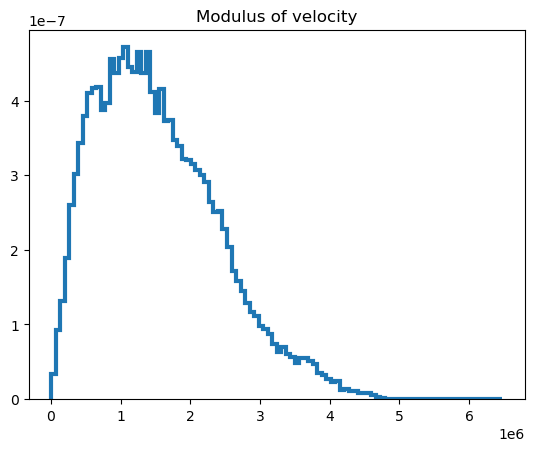

In [4]:
#Ploting histogram: 
plt.figure()
n, bins, patches = plt.hist(modulus_v.flatten(), 100, histtype = "step", lw = 3.0, density = True)
plt.title("Modulus of velocity")
plt.show()

The distribution of this histograms is *similar* to the histogram of the **logaritimic distribution** of exercise 3

### Part D

In [76]:
#Defining the functions:
def aver(vx1,vx2):
    '''
    This functions calculates the average velocity
    -------------------------------------------------------------------------
    PARAMETERS: 
    -vx1_2D,vx2_2D: 2D normalied compnents vectors of the velocity
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns average velocity
    -------------------------------------------------------------------------
    '''
    #Modulus: 
    modulus = np.sqrt(vx1**2 + vx2**2)
    
    #Calculating the average: 
    average = sum(modulus)/len(modulus)
    
    return average

def rms (vx1,vx2):
    '''
    This functions calculates the rms velocity
    -------------------------------------------------------------------------
    PARAMETERS: 
    -vx1_2D,vx2_2D: 2D normalied compnents vectors of the velocity
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns rms velocity
    -------------------------------------------------------------------------
    '''
    #Modulus: 
    modulus = np.sqrt(vx1**2 + vx2**2)
            
    #Calculating the rms: 
    rms = np.mean(modulus**2)
    
    return rms

def volume_average(average,rms):
    '''
    This functions calculates volume-weighted average velocity dispersion
    -------------------------------------------------------------------------
    PARAMETERS: 
    -average,rms:avrage and rms velocities
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns volume-weighted average velocity
    -------------------------------------------------------------------------
    '''
    # calcualting the vwa disspersion: 
    disp = np.sqrt(rms-average**2)
    
    return disp


def Mach_number(average,c): 
    '''
    This functions Mach number 
    -------------------------------------------------------------------------
    PARAMETERS: 
    -v_average, c: average velocity of and speed of sound
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns Mach number 
    -------------------------------------------------------------------------
    '''
    # Mach = v/c: 
    Mach_number = average/c
    
    return Mach_number


def plot(time, array, y_axis_name,path):
    '''
    This functions make plots of the INPUT array vs time 
    ------------------------------------------------------------------------------
    PARAMETERS: 
    -array , time : array containing the values to plot
    -y_name_axis : name of y axis for the plot
    ------------------------------------------------------------------------------
    OUTPUT:
    -Returns saved plots of eahc of the quatities vs time
    -------------------------------------------------------------------------
    '''
    #Ploting: 
    plt.figure()
    plt.plot(time, array ,marker = "d")
    plt.xlabel("Time")
    plt.ylabel(y_axis_name)
    plt.savefig(path + "/"+ y_axis_name + ".jpg")
    plt.close()
    

In [68]:
#Reading the data
time_data = pd.read_csv(vtk_path,sep='\s+',header=None)
    
#Reading the units file
units = pd.read_csv(units_path)
vel_0 = np.array(units.loc[units["variable"] == "v_0"]["normalisation"])
c_iso = np.array(units.loc[units["variable"] == "c_iso"]["normalisation"])
    
#time array: 
time = time_data.iloc[:,1]
    
#normalization value:
norm = l_0/vel_0
    
#normalising time: 
time_norm = time*norm

#Creating empy lists to save the values: 
average_velocity, Rms, Volume_disp,Mach_num =[],[],[],[]


#Looping over the files
for i in range (len(time_norm)):
    
    #Path of the file
    files_path = "/home/jdiego/Downloads/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/data.0{:03d}.vtk".format(i)
    
    #Getting the componets of the velocities: 
    vx1,vx2 = read_units(units_path,files_path)
    
    #Getting the average v:
    average = aver(vx1,vx2)
    average_velocity.append(average)
    
    #Getting the rms:
    rms_ = rms(vx1,vx2)
    Rms.append(rms_)
    
    #Calculating the volume dispersion:
    volume = volume_average(average,rms_)
    Volume_disp.append(volume)
    
    #Calculating the mach number:
    mach = Mach_number(average,c_iso[0])
    Mach_num.append(mach)
    

In [79]:
#Converting into arrays:
average_velocity = np.array(average_velocity)
Rms  = np.array(Rms)
Volume_disp = np.array(Volume_disp)
Mach_num = np.array(Mach_num)


#Making the the path fot the directory: 
path = "/home/jdiego/Documents/Computacional_1/out_results"

#Creating the directory: 
os.makedirs(path)

# Creating data frame
df = pd.DataFrame({"time": time_norm, "Average Velocity": average_velocity, \
                  "Rms": Rms, "Volume disspersion":Volume_disp, \
                  "Mach Number": Mach_num})

#Saving as csv file:
df.to_csv("/home/jdiego/Documents/Computacional_1/out_results/output.csv", sep=',', float_format='{:.2e}'.format)

#Saving the plots: 
plot(time,Rms , 'Rms',path)
plot(time,average_velocity , 'Average velocity',path)
plot(time,Volume_disp , 'Volume-weighted average velocity dispersion',path)
plot(time,Mach_num , 'Mach Number',path)


### Part E

In [87]:
#Creating functions to plot and save: 

def plot_map(x_2d, y_2d, modulus_v):
    '''
    This functions make plots of modulus of velocity for each time 
    ------------------------------------------------------------------------------
    PARAMETERS: 
    -x_2d, y_2d, modulus_v
    ------------------------------------------------------------------------------
    OUTPUT:
    -Returns saved plots of the modulus 
    -------------------------------------------------------------------------
    '''
    #Plotting modulus of velocity:
    plt.figure(figsize = (10,8))
    Z = plt.pcolor(x_2d, y_2d, modulus_v, cmap = "viridis")
    plt.title("Modulus of velocity")
    plt.colorbar(Z)
    plt.savefig(path + "/data.0{:03d}.jpg".format(i))
    plt.close()
    
    
def plt_mach(time,mach):
    '''
    This functions make plots of the Mach number vs time 
    ------------------------------------------------------------------------------
    PARAMETERS: 
    -time, mach
    ------------------------------------------------------------------------------
    OUTPUT:
    -Returns saved plots of eahc of the Mach number vs time
    -------------------------------------------------------------------------
    '''
    #Ploting: 
    plt.figure()
    plt.plot(time, mach ,marker = "d")
    plt.xlabel("Time")
    plt.ylabel("Mach number")
    plt.savefig(path + "/Mach.0{:03d}.jpg".format(i))
    plt.close()

In [90]:
#We first create a directory to save the plots and maps for each time:
path = "/home/jdiego/Documents/Computacional_1/out_result_plots"

#Creating the directory: 
os.makedirs(path)

#Creating empty lists to save the values of mach# per each time
mach_l = []
time_l = []

#Loop over the files to create the plots:
for i in range(len(time_norm)):
    #Path of the file
    files_path = "/home/jdiego/Downloads/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/data.0{:03d}.vtk".format(i)
    
    #Getting the componets of the velocities: 
    vx1,vx2 = read_units(units_path,files_path)
    
    #Reshaping:
    data   = pv.read(files_path)
    vx1_2D = vx1.reshape(data.dimensions[0] - 1, data.dimensions[1] - 1)
    vx2_2D = vx2.reshape(data.dimensions[0] - 1, data.dimensions[1] - 1)

    #Calculaing the modulus: 
    modulus_v = np.sqrt(vx1_2D**2 + vx2_2D**2)
    
    #Calclating the average:
    average = aver(vx1,vx2)
    
    #Ploting the maps:
    plot_map(x_2d, y_2d, modulus_v)
    
    #calculatign mach number: 
    mach = Mach_number(average,c_iso[0])
    
    #Appending to the list to save the values
    mach_l.append(mach)
    time_l.append(time_norm[i])
    
    #Ploting mach numbers: 
    plt_mach(time_l,mach_l)

In [92]:
#Creating the movie function: 
def movie(images_input,name):
    '''
    This functions creates a movie with the images from a given directory
    ----------------------------------------------------------------------
    Parameters: 
    -imeges_input, name(name to save the giff)
    -----------------------------------------------------------------------
    RETURNS: a giff of the images
    ------------------------------------------------------------------------
    '''
    path =  "/home/jdiego/Documents/Computacional_1/out_result_plots/"+name+".pillow.gif"
    
    #Collect the images
    imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

    img = next(imgs)

    img.save(fp = path, format="GIF", append_images=imgs,\
        save_all=True, duration = 100, loop = 0)

In [95]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Here i'm saving the gifs in the same directory with the plots.
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#Creating the giffs
input1 = "/home/jdiego/Documents/Computacional_1//out_result_plots/data.***.jpg"
input2 = "/home/jdiego/Documents/Computacional_1/out_result_plots/Mach.***.jpg"
name1 = "Velocity Modulus"
name2 = "Mach Number"
movie(input1,name1)
movie(input2,name2)

The flow dot not get a completely steady state but it becomes more stalbe along the given period of time. Since it is a **Isothermal gas** it makes senc that it reaches a steady state. 